# Homework week 11/12 - Paolo Zinesi

Simulation of the stochastic dynamics of the two stage model,

$$
\begin{cases}
    0 \xrightarrow{\nu_0} \text{mRNA},\\
    \text{mRNA} \xrightarrow{d_0} 0,\\
    \text{mRNA} \xrightarrow{\nu_1} \text{mRNA + protein},\\
    \text{protein} \xrightarrow{d_1} 0,\\
\end{cases}
$$
where $c_j\, dt$ is the probability for a single molecule involved in the reaction $j$ to react in the infinitesimal time $dt$, and $a_j(\boldsymbol{x})\, dt$ is the probability that a reaction $j$ will occurr in the infinitesimal time $dt$, given that the system is in the state $\boldsymbol{x}$.

In our specific case $\boldsymbol{x} = (m,n) = (\text{mRNA}, \text{proteins})$.


## Gillespie algorithm
Consider a stochastic dynamics with different reactions $j=1,\dots,M$ that occurr simultaneously with rates $a_j(\boldsymbol{x})$ and define $\boldsymbol{x} = \boldsymbol{x}(t)$ as the state vector of the system at time $t$. The probability that the reaction $j$ occurs in the time $(t+\tau, t+\tau+d\,t)$ is

$$ p(\tau,j|\boldsymbol{x},t)d\,t = a_j(\boldsymbol{x}) \exp{\left[ -\left(\sum_j a_j(\boldsymbol{x}) \right) \tau\right]} d\,t.$$

This is an exponential distrubtion with rate $a_0(\boldsymbol{x}) = \sum_j a_j(\boldsymbol{x})$, that is the reciprocal of the average $\tau$. When a reaction $j$ occurs, the state of the system is modified such that $\boldsymbol{x} \leftarrow \boldsymbol{x} + \boldsymbol{v}_j$.
The **Gillespie's algorithm** to simulate stochastic dynamics with $M$ reactions proceeds as follows:

0. Initialize $\boldsymbol{x} = \boldsymbol{x}(0)$ and set $t=0$.
1. Evaluate the rates $a_j(\boldsymbol{x})$ for each reaction and the total rate $a_0(\boldsymbol{x}) = \sum_j a_j(\boldsymbol{x})$.
2. Draw the time period to the next reaction $\tau$ from the distribution $\text{Exp}(\tau | \lambda=a_0(\boldsymbol{x}))$.
3. Draw the reaction $j$ that occurs at time $\tau$, according to the probability $p(j)=a_j(\boldsymbol{x})/a_0(\boldsymbol{x})$.
4. Update the state $\boldsymbol{x} \leftarrow \boldsymbol{x} + \boldsymbol{v}_j$ and go back to point 1 until convergence.


In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

## Functions to define the two stage model

In [2]:
def Gillespie_iteration_2stagemodel(x, t, args=(1,1,1,1)):
    """
        input:
            - x: vector containing input (m,n) values. Size = (2)
            - t: time
            - args: two stage model constants [nu0, d0, nu1, d1]
        
        output: same as input but updated to the next iteration
        
    """
    m, n = x
    nu0, d0, nu1, d1 = args

    # propensities
    a1 = nu0
    a2 = d0 * m
    a3 = nu1 * m
    a4 = d1 * n
    a_j = np.array([a1, a2, a3, a4])

    # total propensity (rate)
    a0 = np.sum(a_j)

    # dt of next reaction
    tau = (1./a0)*np.log(1/random.random_sample())

    # choice of next reaction index (j)
    j_next = random.choice(len(a_j), p=a_j/a0)
    #j_next = np.argmax(np.cumsum(a_j) >= random.random_sample()*a0)

    # updates
    v1 = [1, 0]
    v2 = [-1, 0]
    v3 = [0, 1]
    v4 = [0, -1]
    v_j = np.array([v1, v2, v3, v4])

    # perform updates (the only nonzero value is j)
    x = x + v_j[j_next,:]
    t = t + tau

    return x, t


def meanfield_2stagemodel(t, x0, args=(1,1,1,1)):
    """
        input:
            - t: time. Size = (Nt)
            - x0: [m,n] values at time t=0
            - args: two stage model constants [nu0, d0, nu1, d1]
        
        output: vector containing [m,n] values. Size = (2, Nt)
        
    """
    m0, n0 = x0
    nu0, d0, nu1, d1 = args

    if d0 != d1:
        F_t = (np.exp(-d0*t)-np.exp(-d1*t))/(d1-d0)
    else:
        F_t = t * np.exp(-d1*t)

    return np.array([nu0/d0 + (m0 - nu0/d0)*np.exp(-d0*t),
                     (nu0*nu1)/(d0*d1) + (n0 - (nu0*nu1)/(d0*d1))*np.exp(-d1*t) + nu1*(m0 - nu0/d0)*F_t])

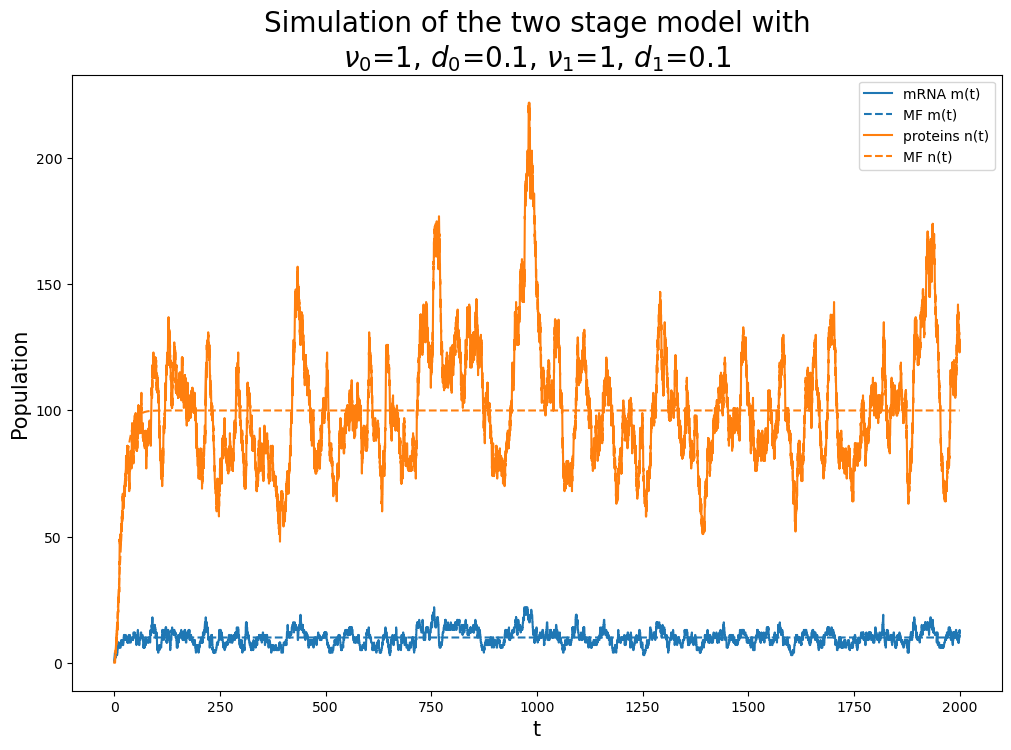

In [3]:
# initialization
t = 0.0
x = [0,0]
m_t, n_t, t_t = [], [], []
nu0, d0, nu1, d1 = 1, 0.1, 1, 0.1
args = [nu0, d0, nu1, d1]

# Gillespie iterations
tmax=2.0e3
while t<tmax:
    x, t = Gillespie_iteration_2stagemodel(x, t, args)
    m_t.append(x[0])
    n_t.append(x[1])
    t_t.append(t)

# Mean field solution
t0 = np.linspace(0, tmax, num=1000)
m_MF_t, n_MF_t = meanfield_2stagemodel(t0, [0,0], args)


# plots
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(t_t, m_t, label="mRNA m(t)")
ax.plot(t0, m_MF_t, "--", color="C0", label="MF m(t)")
ax.plot(t_t, n_t, label="proteins n(t)")
ax.plot(t0, n_MF_t, "--", color="C1", label="MF n(t)")

ax.set_title("Simulation of the two stage model with\n" + fr"$\nu_0$={nu0}, $d_0$={d0}, $\nu_1$={nu1}, $d_1$={d1}", fontsize=20)
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("Population", fontsize=15)
ax.legend()

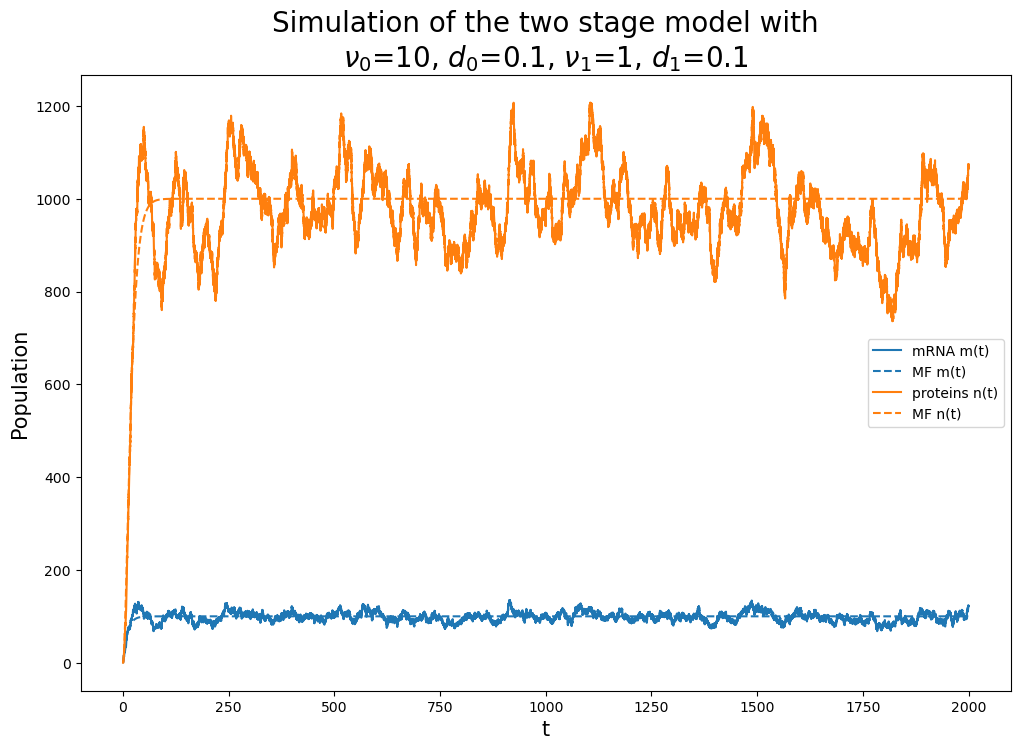

In [4]:
# initialization
t = 0.0
x = [0,0]
m_t, n_t, t_t = [], [], []
nu0, d0, nu1, d1 = 10, 0.1, 1, 0.1
args = [nu0, d0, nu1, d1]

# Gillespie iterations
tmax=2.0e3
while t<tmax:
    x, t = Gillespie_iteration_2stagemodel(x, t, args)
    m_t.append(x[0])
    n_t.append(x[1])
    t_t.append(t)

# Mean field solution
t0 = np.linspace(0, tmax, num=1000)
m_MF_t, n_MF_t = meanfield_2stagemodel(t0, [0,0], args)


# plots
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(t_t, m_t, label="mRNA m(t)")
ax.plot(t0, m_MF_t, "--", color="C0", label="MF m(t)")
ax.plot(t_t, n_t, label="proteins n(t)")
ax.plot(t0, n_MF_t, "--", color="C1", label="MF n(t)")

ax.set_title("Simulation of the two stage model with\n" + fr"$\nu_0$={nu0}, $d_0$={d0}, $\nu_1$={nu1}, $d_1$={d1}", fontsize=20)
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("Population", fontsize=15)
ax.legend()

## Comments on the simulations

From the simulations it is clear that the iterations of the Gillespie algorithm follow the mean field solution **on average**.

However, the time needed to run the simulation will depend on the entity of the sum of the $a_j(\boldsymbol{x})$ probabilities. In fact, at each iteration the algorithm draws from an exponential distribution the time period until the occurrence of the next reaction. The expectation value of the inter-reaction times is the reciprocal of $a_0(\boldsymbol{x}) = \sum_j a_j(\boldsymbol{x})$. This implies that, when the total simulation time is fixed, the increase of one of the reaction rates $a_j(\boldsymbol{x})$ leads to a reduction of the mean inter-reaction times and then to an increase of the reactions to simulate. Therefore, the algorithm simulates efficiently any system dynamics without relying on an externally defined timestep to progress along the simulation, because the inter-reaction times depends only on the reaction rates $a_j(\boldsymbol{x})$. The adaptivity of this algorithm makes it a good tool to efficiently simulate stochastic dynamics with many reactions.